CLUSTERING ALGORITHMS

In [1]:
from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

Data Import + Treatment

In [2]:
def plot_model(model, label_list=None, X=None):
    if label_list is not None:
        labels = label_list
    else:
        labels = model.labels_
    
    if(hasattr(model, '__class__')):
        model_name = model.__class__.__name__
    else:
        model_name = "CustomModel"
        
    palette = plt.get_cmap('tab20')
    unique_labels = sorted(set(labels))

    color_map = {}
    color_map[-1] = (0.6,0.6,0.6,0.6)
    cluster_ids = [l for l in unique_labels if l != -1]
    for i,l in enumerate(cluster_ids):
        color_map[l] = palette(i % 20)

    plt.figure(figsize=(10,7))
    for l in unique_labels:
        mask = labels == l
        label_name = 'noise' if l == -1 else f'cluster {l}'
        plt.scatter(X[mask,1], X[mask,0], s=12, color=color_map[l], label=None, alpha=0.8)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{model_name} clusters (sample size={len(X)}) — clusters={len(cluster_ids)}')
    #plt.legend(markerscale=2, fontsize='small', loc='best')
    plt.tight_layout()
    plt.show()

In [3]:
def plot_if(model, X):
    """
    Plot IsolationForest results with inliers/outliers and anomaly score heatmap.
    X should be (n_samples, 2) with columns [lat, long]
    """
    labels = model.predict(X)
    scores = model.score_samples(X)
    
    inlier_mask = labels == 1
    outlier_mask = labels == -1
    
    # Create figure with anomaly score heatmap background
    plt.figure(figsize=(12, 8))
    
    # Create mesh for decision boundary
    min_lat, max_lat = X[:, 0].min(), X[:, 0].max()
    min_long, max_long = X[:, 1].min(), X[:, 1].max()
    
    margin_lat = max(0.05 * (max_lat - min_lat), 0.01)
    margin_long = max(0.05 * (max_long - min_long), 0.01)
    
    xx, yy = np.meshgrid(
        np.linspace(min_long - margin_long, max_long + margin_long, 150),
        np.linspace(min_lat - margin_lat, max_lat + margin_lat, 150)
    )
    
    grid = np.c_[yy.ravel(), xx.ravel()]  # [lat, long]
    Z = model.score_samples(grid)
    Z = Z.reshape(xx.shape)
    
    # Plot anomaly score as background
    contourf = plt.contourf(xx, yy, Z, levels=15, cmap='RdYlGn', alpha=0.6)
    plt.colorbar(contourf, label='Anomaly Score (higher=more anomalous)')
    
    # Plot decision boundary (score = 0)
    contour = plt.contour(xx, yy, Z, levels=[0], linewidths=2.5, colors='black', linestyles='dashed')
    
    # Plot training inliers and outliers
    plt.scatter(X[inlier_mask, 1], X[inlier_mask, 0], 
                c='blue', label='Inliers', s=30, edgecolor='darkblue', alpha=0.7)
    plt.scatter(X[outlier_mask, 1], X[outlier_mask, 0], 
                c='red', label='Outliers', s=30, marker='x', linewidth=2)
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'IsolationForest: Inliers vs Outliers (sample size={len(X)}) — outliers={outlier_mask.sum()}')
    plt.legend(markerscale=1.5, fontsize='small', loc='best')
    plt.tight_layout()
    plt.show()


In [4]:
data = pd.read_table("../data/data_cleaned_titles.csv", sep=",")
coords = data[['id','lat','long']].dropna()

'''
sample_size = 1000
if len(coords) > sample_size:
    sample = coords[:sample_size]
    #sample = coords.sample(n=sample_size, random_state=0) If random sampling
else:
    sample = coords
'''

sample = coords
X = sample[['lat','long']].to_numpy()



/tmp/ipykernel_149714/2514882788.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_table("../data/data_cleaned_titles.csv", sep=",")


DBSCAN

DBSCAN randomly selects a data point and checks if it has enough neighbors within a specified radius.
If the point has enough neighbors, it is marked as part of a cluster.
DBSCAN recursively checks if the neighbors also have enough neighbors within the radius until all points in the cluster have been visited.
Repeat steps 1–3 until the remaining data point do not have enough neighbors in the radius.
Remaining data points are marked as outliers.

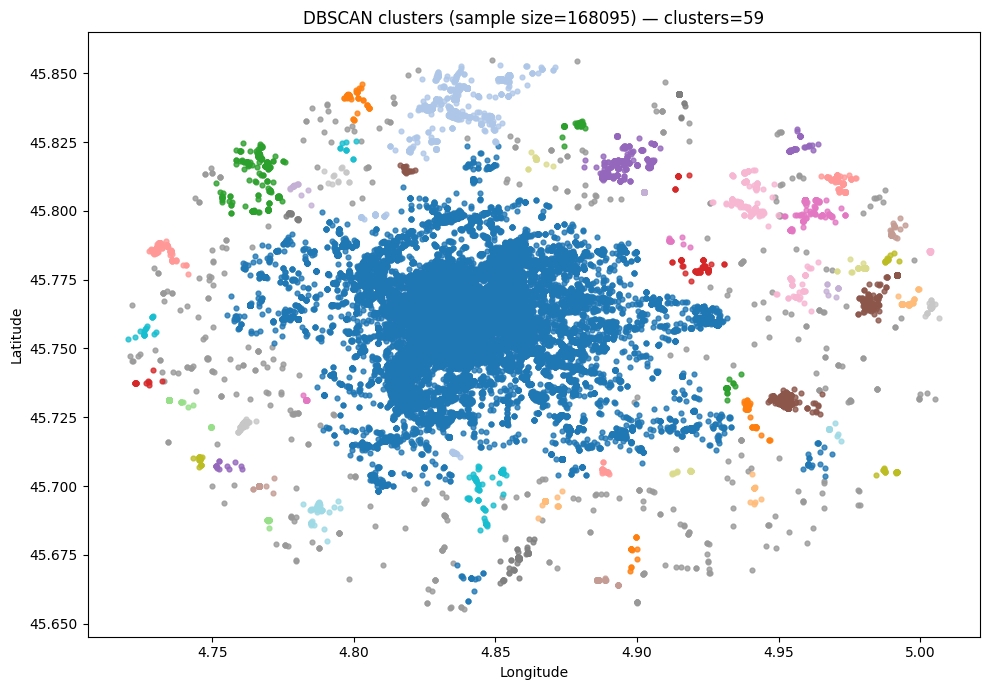

In [5]:
# eps to define max distance to cluster together
# n_jobs parallelises the calculation. -1 means use all processors
dbscan_clusterer = DBSCAN(eps=0.005, min_samples=10, metric='euclidean', n_jobs=-1)
dbscan_clusterer.fit_predict(X)

plot_model(dbscan_clusterer, label_list=None, X=X)



Refining cluster 0 with 140899 points.


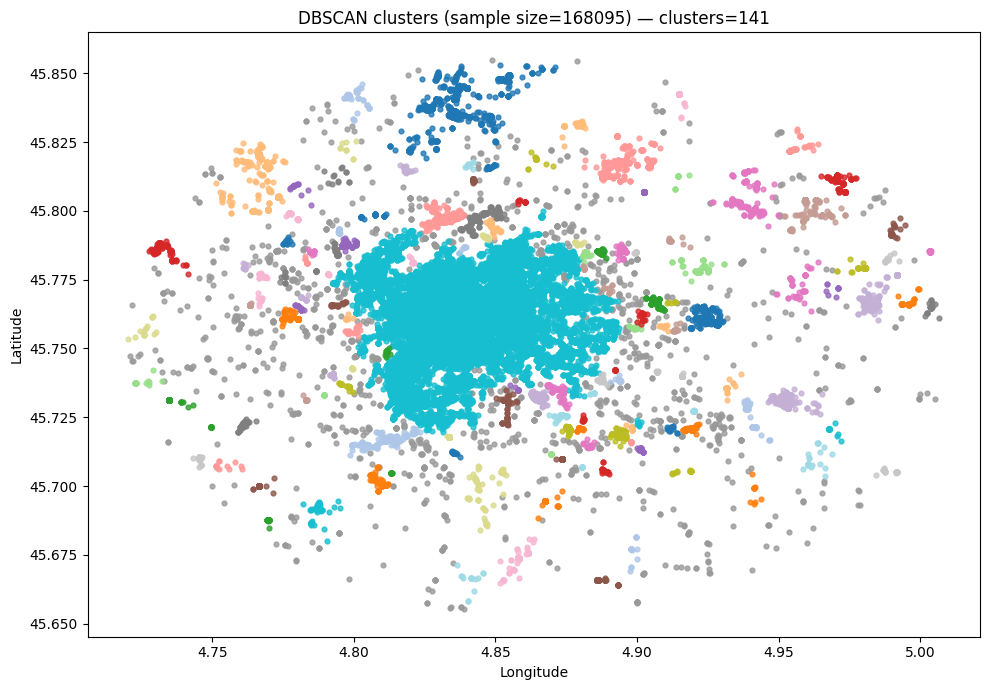

In [6]:
import numpy as np
from collections import Counter

def get_largest_cluster_label(labels):
    counts = Counter(labels)
    counts.pop(-1, None)  # remove noise
    if not counts:
        raise ValueError("No clusters found (only noise).")
    return max(counts, key=counts.get), counts[max(counts, key=counts.get)]

def refine_largest_dbscan_cluster(
    X,
    original_labels,
    new_dbscan_params,
    label_offset=1000
):
    """
    X: array-like (n_samples, n_features)
    original_labels: labels from first DBSCAN
    new_dbscan_params: dict of DBSCAN hyperparameters
    label_offset: integer added to new labels
    """

    X_arr = X.values if hasattr(X, "values") else X
    original_labels = np.asarray(original_labels)

    largest_label, largest_count = get_largest_cluster_label(original_labels)

    print(f"Refining cluster {largest_label} with {largest_count} points.")

    mask = original_labels == largest_label
    X_sub = X_arr[mask]

    new_dbscan = DBSCAN(**new_dbscan_params)
    new_labels_sub = new_dbscan.fit_predict(X_sub)

    new_labels_sub = np.where(
        new_labels_sub != -1,
        new_labels_sub + label_offset,
        -1
    )

    final_labels = original_labels.copy()
    final_labels[mask] = new_labels_sub

    return final_labels, largest_count

labels_dbscan, count = refine_largest_dbscan_cluster(X,
    original_labels=dbscan_clusterer.labels_,
    new_dbscan_params={'eps':0.002, 'min_samples':10, 'metric':'euclidean', 'n_jobs':-1},
    label_offset=1000)

plot_model(dbscan_clusterer, label_list=labels_dbscan, X=X)

In [ ]:
eps = 0.002
iterating_labels = labels_dbscan.copy()
#while(count > 5000):
for i in range(5):
    eps = eps/2

    iterating_labels, count = refine_largest_dbscan_cluster(X,
        original_labels=iterating_labels,
        new_dbscan_params={'eps':eps, 'min_samples':50, 'metric':'euclidean', 'n_jobs':-1},
        label_offset=iterating_labels.max()+1)

plot_model(dbscan_clusterer, label_list=iterating_labels, X=X)

print(len(set(iterating_labels)) - (1 if -1 in iterating_labels else 0))

Refining cluster 4079 with 4976 points.
Refining cluster 4193 with 4976 points.
Refining cluster 4194 with 4976 points.
Refining cluster 4195 with 4976 points.
Refining cluster 4196 with 4976 points.


KeyboardInterrupt: 

HDBSCAN

Next, we have hierarchical clustering. This method starts off by computing a distance matrix from the raw data. This distance matrix is best and often visualized by a dendrogram. Data points are linked together one by one by finding the nearest neighbor to eventually form one giant cluster. Therefore, a cut-off point to identify the clusters by stopping all data points from linking together.

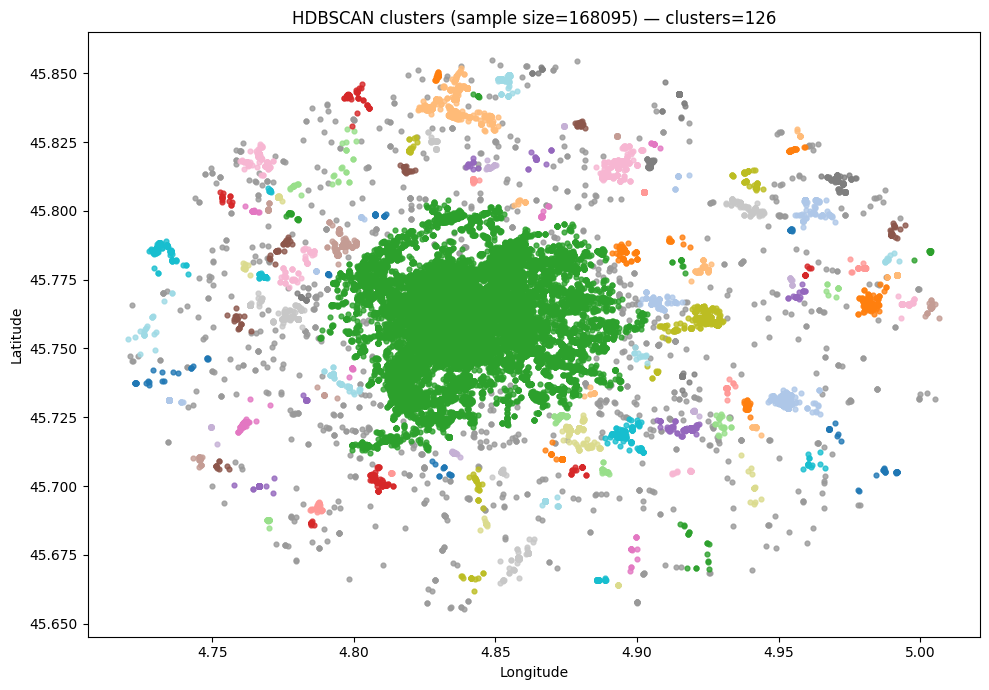

In [36]:
# copy=True makes sure that if there's changes in the data, HDBSCAN makes a safe copy of it
# min_cluster_size defines the min amount of points for a set to be considered a cluster
# cluster_selection_epsilon defines the distance to include a point in a cluster set
# n_jobs parallelises the calculation. -1 means use all processors
# store_centers="centroid" to store avg of a cluster
hdbscan_clusterer = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_epsilon=0.003, copy=True, n_jobs=-1)
hdbscan_clusterer.fit(X)
labels_hdbscan = hdbscan_clusterer.labels_

plot_model(hdbscan_clusterer, label_list=labels_hdbscan, X=X)


In [37]:
def refine_largest_hdbscan_cluster(
    X,
    original_labels,
    new_hdbscan_params,
    label_offset=1000
):
    """
    X: array-like (n_samples, n_features)
    original_labels: labels from first DBSCAN
    new_dbscan_params: dict of DBSCAN hyperparameters
    label_offset: integer added to new labels
    """

    X_arr = X.values if hasattr(X, "values") else X
    original_labels = np.asarray(original_labels)

    largest_label, largest_count = get_largest_cluster_label(original_labels)

    print(f"Refining cluster {largest_label} with {largest_count} points.")

    mask = original_labels == largest_label
    X_sub = X_arr[mask]

    new_dbscan = HDBSCAN(**new_hdbscan_params)
    new_labels_sub = new_dbscan.fit_predict(X_sub)

    new_labels_sub = np.where(
        new_labels_sub != -1,
        new_labels_sub + label_offset,
        -1
    )

    final_labels = original_labels.copy()
    final_labels[mask] = new_labels_sub

    return final_labels, largest_count

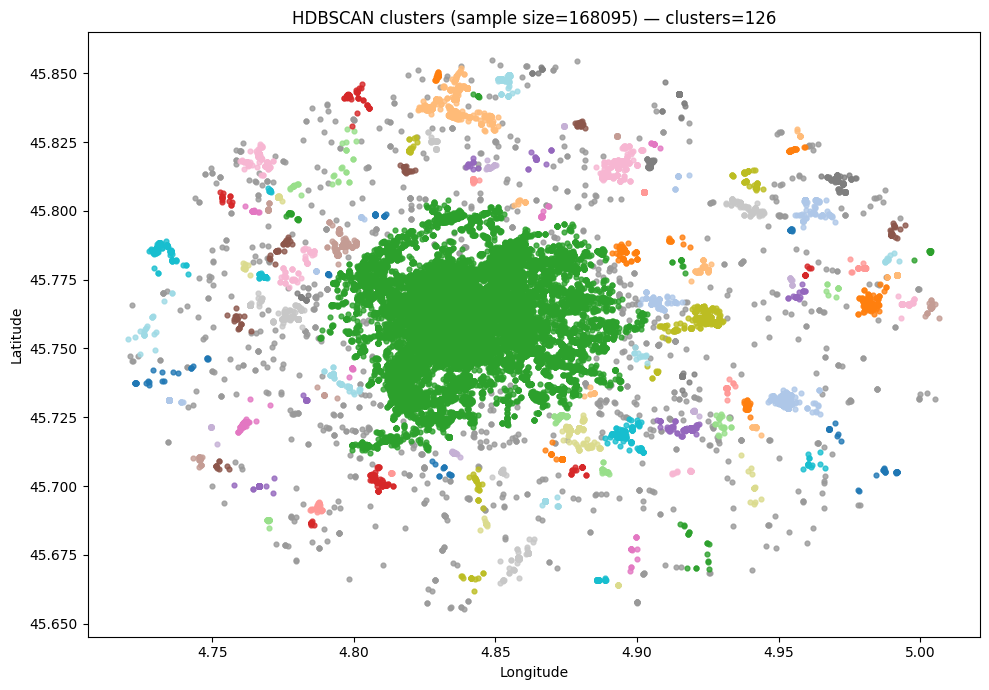

In [39]:
cluster_selection_epsilon = 0.002

while(count > 10000):
    cluster_selection_epsilon = cluster_selection_epsilon/2

    labels_hdbscan, count = refine_largest_hdbscan_cluster(X,
        original_labels=labels_hdbscan,
        new_hdbscan_params={'cluster_selection_epsilon':cluster_selection_epsilon, 'min_cluster_size':5, 'n_jobs':-1},
        label_offset=labels_hdbscan.max()+1)
    print(f"New largest cluster size: {count}")

plot_model(hdbscan_clusterer, label_list=labels_hdbscan, X=X)

In [29]:
# from hdbscan.validity import validity_index

# # calcule un score en fonction de la stabilité des clusters (privilégie donc les plus grands clusters)
# # à voir comment fonctionne exactement

# #une autre façon de faire serait peut-etre d'utiliser la librairie hdbscan, puisqu'ils 
# #nous donnent le dendogram of the merging
# # it also has a feature for automatically selecting the clusters with the maximum score
# # https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
# score = validity_index(X, labels)
# score

K-Means++

K-Means is the most widely used clustering algorithm. The objective is to minimize the sum of distances between the data points and the cluster centroid to identify the correct group that each data point should belong to. IMPORTANT: It is uncapable of filtering out noise, it needs data treating first to work properly.

A defined number of centroids (= number of clusters) are randomly dropped into the vector space of the unlabeled data (initialization).
Each data point measures itself to each centroid (usually using Euclidean distance) and assigns itself to the closest one.
The centroids relocate to the mean of their assigned data points.
Steps 2–3 repeat until the ‘optimal’ clusters are produced.

Kmeans++ tries to find a better initialization, by randomly dropping a centroid and selecting the other centroids as the furthest existing points. This assumes that clusters tend to be further appart.

Sklearn uses Greedy Kmeans++, which attempts different starts to Kmeans++.

To understand: 
As both KMeans and MiniBatchKMeans optimize a non-convex objective function, their clustering is not guaranteed to be optimal for a given random init. Even further, on sparse high-dimensional data such as text vectorized using the Bag of Words approach, k-means can initialize centroids on extremely isolated data points. Those data points can stay their own centroids all along.




[[45.71664066  4.87435997]
 [45.76121469  4.85961193]
 [45.77208787  4.83118835]
 [45.83729589  4.82636636]
 [45.73010963  4.95229752]
 [45.73156362  4.81935806]
 [45.76216688  4.82184375]
 [45.70120205  4.76697324]
 [45.80525338  4.95641701]
 [45.78158017  4.87409066]
 [45.73193312  4.73490467]
 [45.75913737  4.84038239]
 [45.77606839  4.85552797]
 [45.76265969  4.78120384]
 [45.81232844  4.7684304 ]
 [45.7689169   4.98339764]
 [45.81416136  4.89789864]
 [45.68129434  4.86670979]
 [45.75855943  4.83327505]
 [45.77486975  4.80782552]
 [45.76417474  4.92443301]
 [45.79860091  4.83787501]
 [45.76707519  4.83492879]
 [45.75197682  4.88155698]
 [45.72065461  4.92105928]
 [45.75017728  4.83847983]
 [45.76407591  4.85022947]
 [45.84785323  4.85266253]
 [45.76810759  4.8783409 ]
 [45.74100147  4.87041065]
 [45.78458759  4.7328354 ]
 [45.72482069  4.83100779]
 [45.74989032  4.85313645]
 [45.78445469  4.85514223]
 [45.75110897  4.826045  ]
 [45.75950311  4.80948229]
 [45.76800882  4.76440143]
 

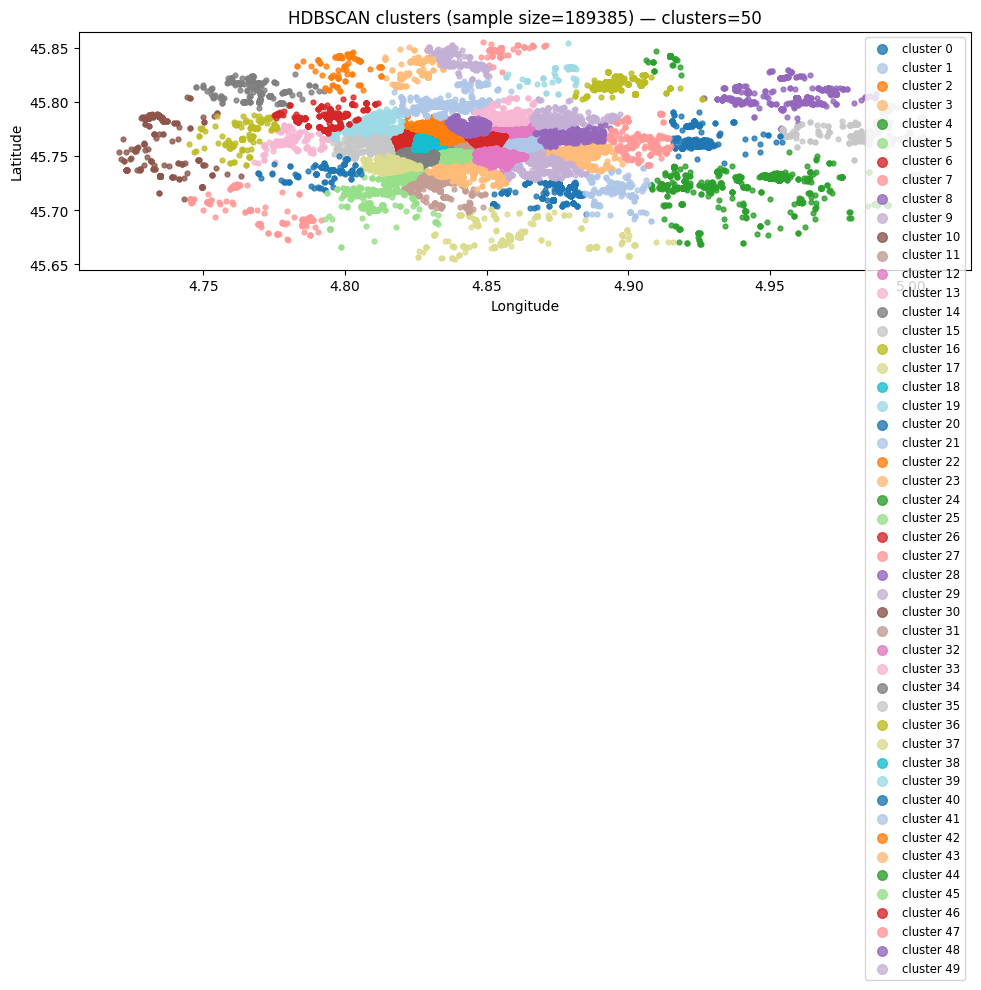

In [ ]:
# n_clustersint, default=8 -> fixes the amount of clusters
# max_iter -> nb of max iterations for a single run (only one run in Kmeans++, n_init for Kmeans)
km_clustering = KMeans(init="k-means++", n_clusters=50, random_state=0)

km_clustering.fit_predict(X)

print(km_clustering.cluster_centers_)

plot_model(km_clustering, label_list=None,X=X)

Isolation Forest

Isolation Forest is not a clustering algorithm, but an anomaly detector one. 
It tries, by using trees, to isolate points. It does that by selecting a random cut (between min and max of lon or lat), and points that get isolated first are considered anomalous.

This makes it so that isolated points are separeted first. The main problem is that it does not handle different concentration clusters nor smaller clusters.

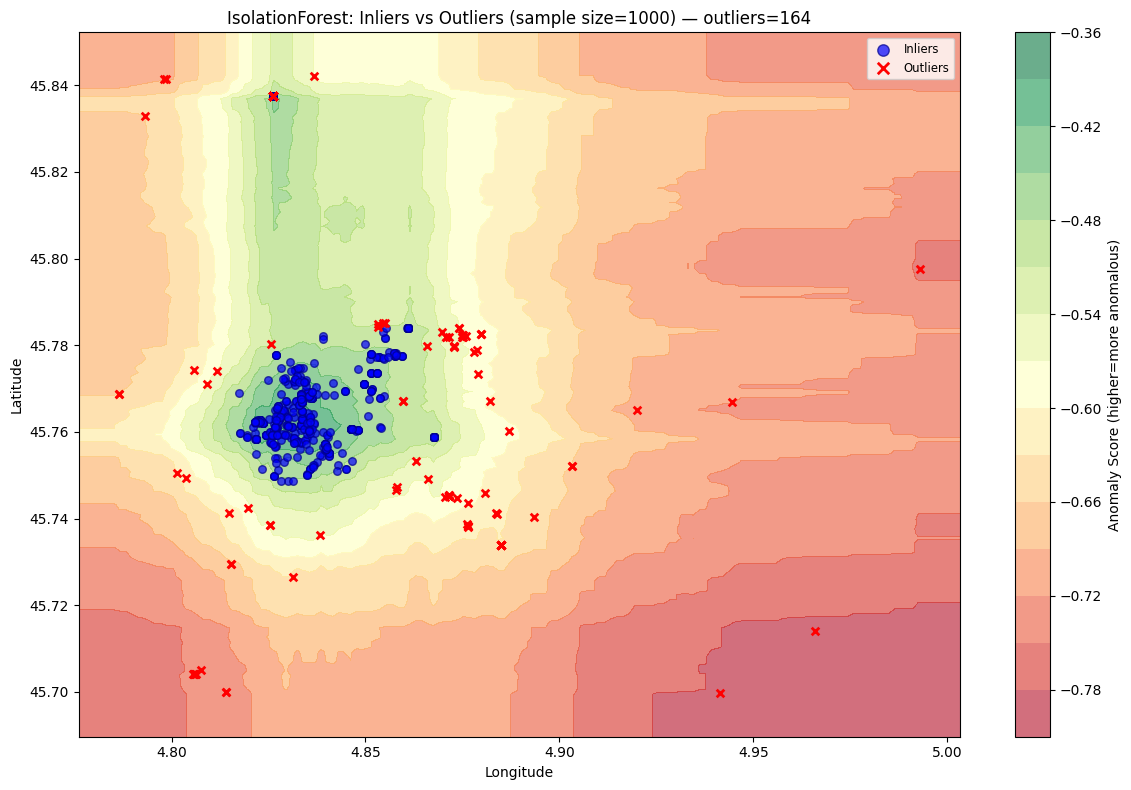

In [ ]:
isof_clustering = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

isof_clustering.fit_predict(X)

plot_if(isof_clustering, X)

POST TRAITEMENT

Nous avons identifié que la concentration des points n'est pas la même pour le cluster du milieu et les autres.

Nous pouvons, alors, run les algorithmes une fois pour définir les classes qui appartienent à la périphérie (bien triées pour les premiers hyperparamètres) et le run une deuxième fois avec des différents hyperparamètres pour mieux définir le cluster du milieu.

In [30]:
def count_points_per_cluster(labels, ignore_noise=True):
    """
    Retourne un DataFrame avec:
    - cluster_id
    - n_points
    """
    s = pd.Series(labels, name="cluster_id")

    if ignore_noise:
        s = s[s != -1]

    counts = (
        s
        .value_counts()
        .rename("n_points")
        .reset_index()
        .sort_values("cluster_id")
        .reset_index(drop=True)
    )

    return counts

In [ ]:
hdbscan_count = count_points_per_cluster(labels_hdbscan)
print(hdbscan_count)

     cluster_id  n_points
0             0        23
1             1        13
2             2        30
3             3        12
4             4        48
..          ...       ...
121         121       162
122         122        98
123         123        15
124         124    135328
125         125        67

[126 rows x 2 columns]


Filling predictions.csv

In [31]:
# Support function
def _infer_model_column(model):
    name = model.__class__.__name__.lower()

    if "hdbscan" in name:
        return "hdbscan"
    elif "dbscan" in name:
        return "dbscan"
    elif "kmeans" in name:
        return "kmean"
    elif "isolationforest" in name:
        return "isolation_forest"
    else:
        raise ValueError(f"Unknown model type: {model.__class__.__name__}")

def write_predictions(
    X,
    models,
    labels_dict=None,
    path="../data/predictions.csv"
):
    """
    models : list of fitted models
    labels_dict : optional dict {model: labels}
    """

    preds = pd.read_csv(path)

    if "id" not in preds.columns:
        raise ValueError("predictions.csv must contain an 'id' column")

    if "id" not in X.columns:
        raise ValueError("X must contain an 'id' column")

    base = pd.DataFrame({"id": X["id"].values})

    for model in models:
        column = _infer_model_column(model)

        if labels_dict and model in labels_dict:
            labels = labels_dict[model]
        else:
            if hasattr(model, "labels_"):
                labels = model.labels_
            else:
                raise ValueError(f"No labels for {model}")

        if len(X) > len(labels):
            raise ValueError("X length greater than labels")

        base[column] = labels

    preds.update(base) 

    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    preds.to_csv(path, index=False)

# Creates header for the predictions.csv file
def initialize_predictions_from_cleaned(
    cleaned_path="../data/data_cleaned_titles.csv",
    output_path=""
):
    df = pd.read_csv(cleaned_path)
    print(df.head())
    if "id" not in df.columns:
        raise ValueError("data_cleaned.csv must contain an 'id' column")

    preds = pd.DataFrame({
        "id": df["id"],
        "hdbscan": pd.NA,
        "dbscan": pd.NA,
        "kmean": pd.NA,
        "isolation_forest": pd.NA
    })

    preds.to_csv(output_path, index=False)

In [32]:
def initialize_centroids_from_cleaned(output_path):
    preds = pd.DataFrame(columns=["algo", "cluster_id", "lat", "long", "n_points"])
    preds.to_csv(output_path, index=False)

# Extract and save cluster centroids to a CSV file
def extract_cluster_centroids(
    X,
    models,
    labels_dict=None,
    path="../data/centroids.csv"
):
    """
    models : list of fitted models
    labels_dict : optional dict {model: labels}
    """
    all_cluster_centroids = []

    for model in models:
        algo = model.__class__.__name__.lower()

        if labels_dict and model in labels_dict:
            labels = labels_dict[model]
        else:
            if hasattr(model, "labels_"):
                labels = model.labels_
            else:
                raise ValueError(f"No labels for {model}")

        count = count_points_per_cluster(labels)

        # ---------- KMEANS ----------
        if "kmeans" in algo:
            centers = model.cluster_centers_

            cluster_centroids = [
                {
                    "algo": "kmean",
                    "cluster_id": i,
                    "lat": centers[i][0],
                    "long": centers[i][1],
                    "n_points": int(count[count["cluster_id"] == i]["n_points"]) if i in count["cluster_id"].values else -1
                }
                for i in range(len(centers))
            ]

        # ---------- DBSCAN / HDBSCAN ----------
        elif "dbscan" in algo or "hdbscan" in algo:
            df = X.copy()
            df["cluster"] = labels

            # ignorer le bruit
            df = df[df["cluster"] != -1]

            centroids = (
                df
                .groupby("cluster")[["lat", "long"]]
                .mean()
                .reset_index()
            )

            cluster_centroids = [
                {
                    "algo": "hdbscan" if "hdbscan" in algo else "dbscan",
                    "cluster_id": row["cluster"],
                    "lat": row["lat"],
                    "long": row["long"], 
                    "n_points": int(count[count["cluster_id"] == row["cluster"]]["n_points"].iloc[0])
                }
                for _, row in centroids.iterrows()
            ]

        else:
            raise ValueError(f"Unsupported model type: {model.__class__.__name__}")

        all_cluster_centroids.extend(cluster_centroids)

    # ---------- ÉCRITURE CSV ----------
    df_new = pd.DataFrame(all_cluster_centroids)

    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    
    if path.exists():
        df_old = pd.read_csv(path)
        if "n_points" not in df_old.columns:
            df_old["n_points"] = pd.NA

        # remove old lines for all new algos
        new_algos = df_new["algo"].unique()
        df_old = df_old[~df_old["algo"].isin(new_algos)]

        df = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df = df_new

    df.to_csv(path, index=False)

    return df_new

In [ ]:

# initialize_predictions_from_cleaned(cleaned_path="../data/data_cleaned_titles.csv",output_path="../data/pred_recursive.csv")
# initialize_centroids_from_cleaned(output_path="../data/centroids_recursive.csv")


/tmp/ipykernel_114883/333563811.py:65: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(cleaned_path)


             id          user        lat      long  \
0  4.395181e+09  30624617@N03  45.754858  4.821710   
1  4.394749e+09  35853470@N00  45.753270  4.862953   
2  4.394695e+09  11817998@N05  45.760655  4.846564   
3  4.394804e+09  11545749@N06  45.784000  4.874072   
4  4.394804e+09  11545749@N06  45.784000  4.874072   

                                           tags                 title  \
0                 chair rhone chaise rhonealpes      chaises avec vue   
1                                           NaN                   NaN   
2                                    365 iphone   59365 r46 v103 b163   
3  nin nineinchnails gift screening toiou avott  20100129 toiou avott   
4  nin nineinchnails gift screening toiou avott  20100128 toiou avott   

   date_taken_minute  date_taken_hour  date_taken_day  date_taken_month  \
0               11.0             15.0            28.0               2.0   
1               51.0             17.0            28.0               2.0   
2          

[124 124 124 ...  61  61 124]


In [33]:
models = [dbscan_clusterer]
labels_dict = {dbscan_clusterer: labels_dbscan}
write_predictions(path="../data/pred_recursive.csv",models=models, labels_dict=labels_dict, X=sample)
extract_cluster_centroids(path="../data/centroids_recursive.csv",models=models, labels_dict=labels_dict, X=sample)

,algo,cluster_id,lat,long,n_points
0,dbscan,2.0,45.841200,4.799387,83
1,dbscan,3.0,45.698145,4.941261,13
2,dbscan,4.0,45.831382,4.879024,219
3,dbscan,5.0,45.731335,4.734656,873
4,dbscan,6.0,45.779221,4.922833,133
...,...,...,...,...,...
3233,dbscan,4188.0,45.780099,4.848618,50
3234,dbscan,4189.0,45.779840,4.848253,7
3235,dbscan,4190.0,45.784262,4.852384,15
3236,dbscan,4191.0,45.778703,4.847180,10
